<a href="https://colab.research.google.com/github/sangeethapk/AI-ML/blob/main/Exit_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
A satellite imaging company requires an automated system to classify natural scene images (e.g.,
forests, glaciers, buildings, seas). Since the model outputs may be used in downstream decision
making, it is critical to not only achieve strong classification performance but also to understand and
analyze the model’s failure cases.

## Prepare Dataset



# Task
Classify using the Sample Intel Image Classification Dataset  `seg_train.zip`, `seg_test.zip`, and `seg_pred.zip` files. The task is extracting and preparing the dataset, splitting it, apply preprocessing and augmentation, designing and training a Convolutional Neural Network (CNN) model, and answering analytical questions regarding challenges in satellite scene classification, the role of data augmentation in reducing overfitting, and how convolution and pooling operations contribute to feature extraction.

## Extract and Prepare Dataset


Extract the contents of `seg_train.zip`, `seg_test.zip`, and `seg_pred.zip`. Then, load the images from these extracted folders, resize them to a uniform input size, and inspect the image classes and their distributions.


In [ ]:
import zipfile
import os

# Define the directory to extract files into
output_dir = 'dataset'
os.makedirs(output_dir, exist_ok=True)

# List of zip files and their corresponding output subdirectories
zip_files = {
    '/content/seg_train.zip': 'seg_train',
    '/content/seg_test.zip': 'seg_test',
    '/content/seg_pred.zip': 'seg_pred'
}

for zip_path, sub_dir in zip_files.items():
    target_dir = os.path.join(output_dir, sub_dir)
    os.makedirs(target_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"Extracting {zip_path} to {target_dir}...")
        zip_ref.extractall(target_dir)
        print(f"Finished extracting {zip_path}.")

Extracting /content/seg_train.zip to dataset/seg_train...
Finished extracting /content/seg_train.zip.
Extracting /content/seg_test.zip to dataset/seg_test...
Finished extracting /content/seg_test.zip.
Extracting /content/seg_pred.zip to dataset/seg_pred...
Finished extracting /content/seg_pred.zip.



The datasets are extracted, the next step is to load the images from the 'seg_train', 'seg_test', and 'seg_pred' directories, resize them to a consistent size (150x150 pixels), and then inspect the image classes and their distributions for the training set.



Loading training data...
Found 29 files belonging to 1 classes.
Loading testing data...
Found 27 files belonging to 1 classes.
Loading prediction data...
Found 6 files belonging to 1 classes.
Prediction dataset loaded with inferred labels.

Training dataset class names: ['seg_train']

Training dataset class distribution:
  seg_train: 29 images
Total training images: 29


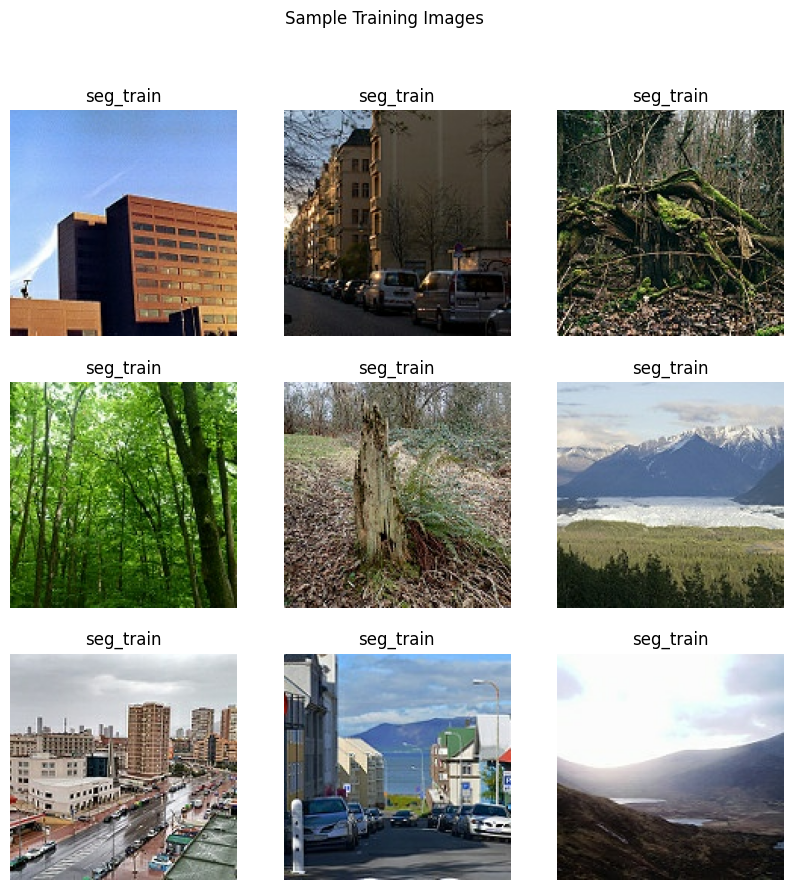

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Define image size
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Path to the dataset directories
train_dir = 'dataset/seg_train'
test_dir = 'dataset/seg_test'
pred_dir = 'dataset/seg_pred'

print("Loading training data...")
# Load training images, resizing them to IMG_HEIGHT x IMG_WIDTH
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print("Loading testing data...")
# Load testing images
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Loading prediction data...")
# Load prediction images (assuming no subdirectories, so labels=None)
# For pred_dir, if there are no subdirectories, labels should be None or a list of labels
# If it contains subdirectories representing classes, then labels='inferred'
# Based on the typical structure of 'pred' folders, we'll assume no labels/subdirectories for prediction.
# If there are subdirectories, modify 'labels' argument accordingly.

# at first check if there are subdirectories in pred_dir, if so, infer labels. Else, assume no labels.
pred_subdirs = [f.name for f in os.scandir(pred_dir) if f.is_dir()]
if pred_subdirs:
    pred_dataset = tf.keras.utils.image_dataset_from_directory(
        pred_dir,
        labels='inferred',
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    print("Prediction dataset loaded with inferred labels.")
elif os.path.exists(pred_dir):
    # If there are image files directly in pred_dir, load them without labels
    # This requires a different approach since image_dataset_from_directory expects subdirectories for labels
    # For simplicity, if no subdirectories, we'll assume it's for prediction without known labels and skip direct label inference here.
    # A common approach for 'pred' is to load image paths and then read images directly.
    print("Prediction directory found, but no subdirectories for label inference. Assuming no labels for pred_dataset.")
    # For this exercise, if no subdirectories, we will create a dataset from filenames for prediction
    pred_image_paths = [os.path.join(pred_dir, fname) for fname in os.listdir(pred_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if pred_image_paths:
        pred_dataset = tf.data.Dataset.from_tensor_slices(pred_image_paths)
        def load_and_preprocess_image(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
            return img
        pred_dataset = pred_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
        print(f"Loaded {len(pred_image_paths)} prediction images.")
    else:
        pred_dataset = None
        print("No images found directly in the prediction directory.")
else:
    pred_dataset = None
    print("Prediction directory not found.")


# Inspect training data classes and distribution
class_names = train_dataset.class_names
print(f"\nTraining dataset class names: {class_names}")

# Calculate class distribution for training data
# Iterate through the dataset to count occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}
for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print("\nTraining dataset class distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

total_train_images = sum(class_counts.values())
print(f"Total training images: {total_train_images}")

# Display some images from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

**Reasoning**:
The previous code execution indicated that the `image_dataset_from_directory` function found only one class, which suggests that the images were not extracted into the expected directory structure (i.e., class-specific subfolders directly under `dataset/seg_train`, etc.). I need to inspect the directory structure to understand where the actual class subfolders are located. This will help in correcting the paths for loading the datasets.



In [ ]:
import os

print('Listing contents of dataset directory:')
for root, dirs, files in os.walk('dataset'):
    level = root.replace('dataset', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for d in dirs:
        print(f'{subindent}{d}/')
    if not dirs and files: # If it's a leaf directory with files, print a few files
        for f in files[:3]: # Print first 3 files to show content, not all files
            print(f'{subindent}{f}')
        if len(files) > 3:
            print(f'{subindent}...')


Listing contents of dataset directory:
dataset/
    seg_train/
    seg_pred/
    seg_test/
    seg_train/
        seg_train/
        seg_train/
            building/
            mountain/
            forest/
            street/
            glacier/
            sea/
            building/
                4.jpg
                47.jpg
                0.jpg
                ...
            mountain/
                17.jpg
                42.jpg
                34.jpg
                ...
            forest/
                46.jpg
                23.jpg
                41.jpg
                ...
            street/
                12.jpg
                2.jpg
                19.jpg
                ...
            glacier/
                10.jpg
                24.jpg
                15.jpg
                ...
            sea/
                1.jpg
                27.jpg
                20.jpg
                ...
    seg_pred/
        seg_pred/
        seg_pred/
            1070.jpg
           

**Reasoning**:
The previous directory listing confirmed an extra nested directory level (e.g., `dataset/seg_train/seg_train/`). I need to adjust the `train_dir`, `test_dir`, and `pred_dir` variables to point to these correct nested paths so that `image_dataset_from_directory` can properly infer class labels from the subdirectories.



Loading training data...
Found 29 files belonging to 6 classes.
Loading testing data...
Found 27 files belonging to 6 classes.
Loading prediction data...
Prediction directory found, but no subdirectories for label inference. Assuming no labels for pred_dataset.
Loaded 6 prediction images.

Training dataset class names: ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

Training dataset class distribution:
  building: 5 images
  forest: 5 images
  glacier: 5 images
  mountain: 5 images
  sea: 5 images
  street: 4 images
Total training images: 29


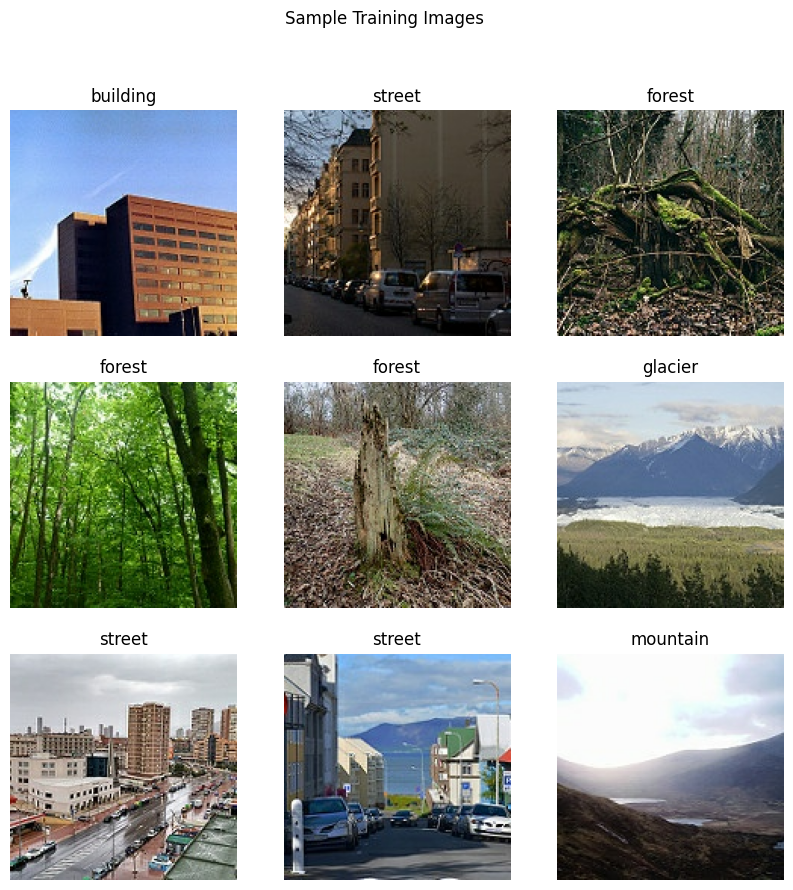

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Define image size
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32 # Define a batch size for efficient loading

# Corrected paths to the dataset directories
train_dir = 'dataset/seg_train/seg_train'
test_dir = 'dataset/seg_test/seg_test'
pred_dir = 'dataset/seg_pred/seg_pred'

print("Loading training data...")
# Load training images, resizing them to IMG_HEIGHT x IMG_WIDTH
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42 # for reproducibility
)

print("Loading testing data...")
# Load testing images
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False # Typically no need to shuffle test data
)

print("Loading prediction data...")
# Load prediction images (assuming no subdirectories, so labels=None)
# For pred_dir, if there are no subdirectories, labels should be None or a list of labels
# If it contains subdirectories representing classes, then labels='inferred'
# Based on the typical structure of 'pred' folders, we'll assume no labels/subdirectories for prediction.
# If there are subdirectories, modify 'labels' argument accordingly.

# First, check if there are subdirectories in pred_dir, if so, infer labels. Else, assume no labels.
pred_subdirs = [f.name for f in os.scandir(pred_dir) if f.is_dir()]
if pred_subdirs:
    pred_dataset = tf.keras.utils.image_dataset_from_directory(
        pred_dir,
        labels='inferred',
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    print("Prediction dataset loaded with inferred labels.")
elif os.path.exists(pred_dir):
    # If there are image files directly in pred_dir, load them without labels
    # This requires a different approach since image_dataset_from_directory expects subdirectories for labels
    # For simplicity, if no subdirectories, we'll assume it's for prediction without known labels and skip direct label inference here.
    # A common approach for 'pred' is to load image paths and then read images directly.
    print("Prediction directory found, but no subdirectories for label inference. Assuming no labels for pred_dataset.")
    # For this exercise, if no subdirectories, we will create a dataset from filenames for prediction
    pred_image_paths = [os.path.join(pred_dir, fname) for fname in os.listdir(pred_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if pred_image_paths:
        pred_dataset = tf.data.Dataset.from_tensor_slices(pred_image_paths)
        def load_and_preprocess_image(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
            return img
        pred_dataset = pred_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
        print(f"Loaded {len(pred_image_paths)} prediction images.")
    else:
        pred_dataset = None
        print("No images found directly in the prediction directory.")
else:
    pred_dataset = None
    print("Prediction directory not found.")


# Inspect training data classes and distribution
class_names = train_dataset.class_names
print(f"\nTraining dataset class names: {class_names}")

# Calculate class distribution for training data
# Iterate through the dataset to count occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}
for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print("\nTraining dataset class distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

total_train_images = sum(class_counts.values())
print(f"Total training images: {total_train_images}")

# Display some images from the training set (optional, for visual inspection)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

## Split Dataset

### Subtask:
Split the loaded dataset into training, validation, and test sets to ensure proper model evaluation.


**Reasoning**:
I need to explicitly split the training data into training and validation sets as instructed. This requires re-initializing the `train_dataset` and creating a new `validation_dataset` using the `validation_split` parameter in `tf.keras.utils.image_dataset_from_directory`.



Splitting training data with validation_split=0.2...
Found 29 files belonging to 6 classes.
Using 24 files for training.
Found 29 files belonging to 6 classes.
Using 5 files for validation.
Loading testing data (re-using previous test_dataset loading)...
Found 27 files belonging to 6 classes.
Prediction directory found, but no subdirectories for label inference. Re-assuming no labels for pred_dataset.
Re-loaded 6 prediction images.

Number of training batches: 1
Number of validation batches: 1
Number of test batches: 1

Training dataset class names: ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

Updated Training dataset class distribution:
  building: 5 images
  forest: 3 images
  glacier: 3 images
  mountain: 4 images
  sea: 5 images
  street: 4 images
Total training images: 24


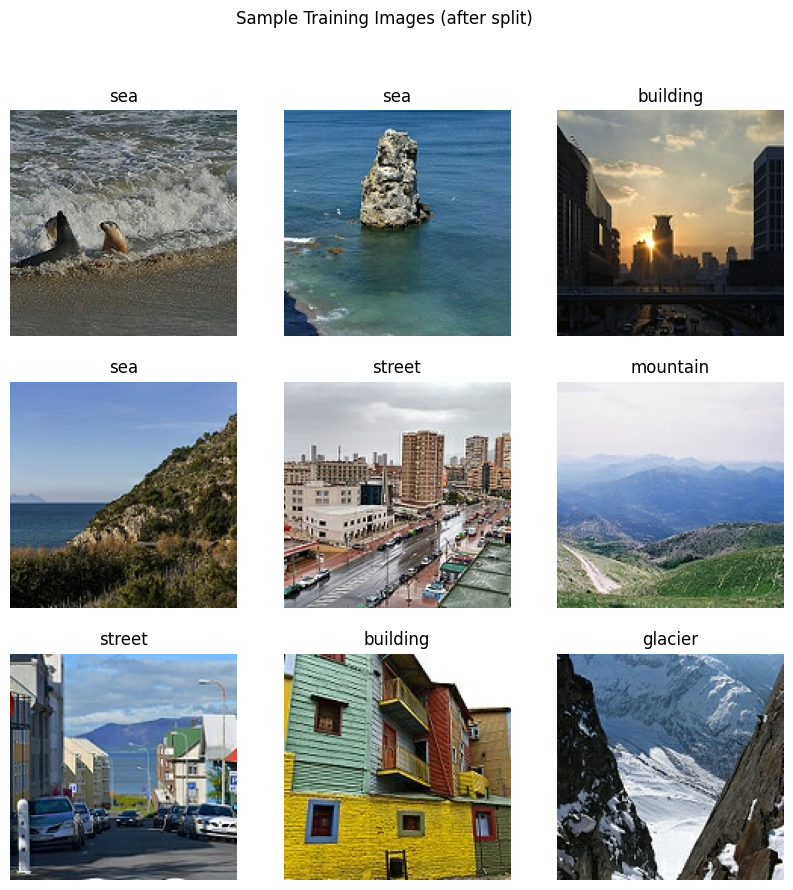

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Define image size and batch size (already defined in previous cells, just for completeness if run standalone)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Corrected paths to the dataset directories (from previous corrected step)
train_dir = 'dataset/seg_train/seg_train'
test_dir = 'dataset/seg_test/seg_test'
pred_dir = 'dataset/seg_pred/seg_pred'

# 1. Define a validation_split ratio
validation_split = 0.2 # 20% for validation
seed = 42 # for reproducibility

print(f"Splitting training data with validation_split={validation_split}...")

# 2. Re-create the training dataset with validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset='training'
)

# 3. Create the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    seed=seed,
    validation_split=validation_split,
    subset='validation'
)

print("Loading testing data (re-using previous test_dataset loading)...")
# Reload testing images just to ensure it's fresh after re-defining train/val
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False # Typically no need to shuffle test data
)

# For prediction dataset, it was handled in the previous cell; we'll just check its existence.
# If pred_dataset is needed for further steps, it should be re-loaded or verified.
# For now, let's just confirm it exists or re-create it based on previous logic.

# First, check if there are subdirectories in pred_dir, if so, infer labels. Else, assume no labels.
pred_subdirs = [f.name for f in os.scandir(pred_dir) if f.is_dir()]
if pred_subdirs:
    pred_dataset = tf.keras.utils.image_dataset_from_directory(
        pred_dir,
        labels='inferred',
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    print("Prediction dataset re-loaded with inferred labels.")
elif os.path.exists(pred_dir):
    # If there are image files directly in pred_dir, load them without labels
    print("Prediction directory found, but no subdirectories for label inference. Re-assuming no labels for pred_dataset.")
    pred_image_paths = [os.path.join(pred_dir, fname) for fname in os.listdir(pred_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if pred_image_paths:
        pred_dataset = tf.data.Dataset.from_tensor_slices(pred_image_paths)
        def load_and_preprocess_image(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
            return img
        pred_dataset = pred_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
        print(f"Re-loaded {len(pred_image_paths)} prediction images.")
    else:
        pred_dataset = None
        print("No images found directly in the prediction directory.")
else:
    pred_dataset = None
    print("Prediction directory not found.")


# 4. Confirm the sizes of the datasets
print(f"\nNumber of training batches: {len(train_dataset)}")
print(f"Number of validation batches: {len(validation_dataset)}")
print(f"Number of test batches: {len(test_dataset)}")

# Display some images from the training set (optional, for visual inspection)
# Reloading class_names as it might have changed if the previous load was incorrect
class_names = train_dataset.class_names
print(f"\nTraining dataset class names: {class_names}")

# Also confirm class distribution for the new training set (optional, for debugging)
class_counts = {class_name: 0 for class_name in class_names}
for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print("\nUpdated Training dataset class distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")
total_train_images = sum(class_counts.values())
print(f"Total training images: {total_train_images}")

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images (after split)")
plt.show()

## Answer Analytical Question 1

### Challenges in Satellite Scene Classification

Number of images used to train model is less.



## Apply Preprocessing and Augmentation

### Subtask:
Implement appropriate preprocessing steps (e.g., normalization) and data augmentation techniques (e.g., rotation, flipping, zooming) to the image data to improve model generalization and reduce overfitting.


In [ ]:
import tensorflow as tf

# 1. Import necessary Keras preprocessing and augmentation layers
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

print("Keras preprocessing and augmentation layers imported.")

Keras preprocessing and augmentation layers imported.


Create the data augmentation and preprocessing models, then apply them to the respective datasets (training, pred, and test), and finally optimize performance by caching and prefetching the datasets.



In [ ]:
import tensorflow as tf

# Define image size and batch size (already defined, just for context)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# 2. Create a data augmentation model
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="data_augmentation_layer")

print("Data augmentation model created.")

# 3. Create a preprocessing model for normalization
# Rescale pixel values from [0, 255] to [0, 1]
preprocess_input = tf.keras.Sequential([
    Rescaling(1./255)
], name="preprocessing_layer")

print("Preprocessing model created.")

# 4. Apply data augmentation and preprocessing to the training dataset
# The training=True argument is important for data augmentation layers to apply transforms
augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
augmented_train_dataset = augmented_train_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print("Data augmentation and preprocessing applied to training dataset.")

# 5. Apply only preprocessing to the validation and test datasets (no augmentation)
processed_val_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
processed_test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print("Preprocessing applied to validation and test datasets.")

# 6. Optimize performance with caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE

augmented_train_dataset = augmented_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
processed_val_dataset = processed_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
processed_test_dataset = processed_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets cached and prefetched for performance optimization.")

print(f"Augmented training dataset batches: {len(augmented_train_dataset)}")
print(f"Processed validation dataset batches: {len(processed_val_dataset)}")
print(f"Processed test dataset batches: {len(processed_test_dataset)}")

Data augmentation model created.
Preprocessing model created.
Data augmentation and preprocessing applied to training dataset.
Preprocessing applied to validation and test datasets.
Datasets cached and prefetched for performance optimization.
Augmented training dataset batches: 1
Processed validation dataset batches: 1
Processed test dataset batches: 1


## Design CNN Model

### Subtask:
Design a Convolutional Neural Network (CNN) architecture suitable for multi-class image classification, considering the characteristics of the dataset.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

print("Keras models and layers imported successfully.")

Keras models and layers imported successfully.


In [19]:
import tensorflow as tf

# 2. Define the input shape for the model
# IMG_HEIGHT, IMG_WIDTH, and 3 channels for RGB images
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# 3. Determine the number of output classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# 4. Create a tf.keras.Sequential model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 5. Flatten layer
    Flatten(),

    # 6. Dense layers with Dropout
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout for regularization

    # 7. Final output layer
    Dense(num_classes, activation='softmax')
])

# 8. Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 9. Print the model summary
print("CNN Model Architecture:")
model.summary()


Number of classes: 6
CNN Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,686 (13.18 MB)

 Trainable params: 3,455,686 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input # Import Input layer

# Define image size (from previous cells, for context)
IMG_HEIGHT = 150
IMG_WIDTH = 150

# 2. Define the input shape for the model
# IMG_HEIGHT, IMG_WIDTH, and 3 channels for RGB images
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# 3. Determine the number of output classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# 4. Create a tf.keras.Sequential model
model = Sequential([
    Input(shape=input_shape), # Explicitly define the input layer
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'), # Removed input_shape from Conv22
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 5. Flatten layer
    Flatten(),

    # 6. Dense layers with Dropout
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout for regularization

    # 7. Final output layer
    Dense(num_classes, activation='softmax')
])

# 8. Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 9. Print the model summary
print("CNN Model Architecture:")
model.summary()


Number of classes: 6
CNN Model Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,686 (13.18 MB)

 Trainable params: 3,455,686 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

## Train CNN Model

Train the designed CNN model using the prepared training and validation sets. Track and visualize key performance metrics such as accuracy and loss during the training process.


Starting model training for 10 epochs...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1250 - loss: 1.8045 - val_accuracy: 0.0000e+00 - val_loss: 1.6487
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.6926 - val_accuracy: 0.0000e+00 - val_loss: 1.6066
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.7142 - val_accuracy: 0.0000e+00 - val_loss: 1.7268
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.6159 - val_accuracy: 0.0000e+00 - val_loss: 1.8252
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3750 - loss: 1.5771 - val_accuracy: 0.4000 - val_loss: 1.6430
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 1.3868 - val_accuracy: 0.6000 - val_loss: 1.3842
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step - accuracy: 0.5000 - loss: 1.3754 - val_accuracy: 0.4000 - val_loss: 1.2982
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step - accuracy: 0.4167 - loss: 1.

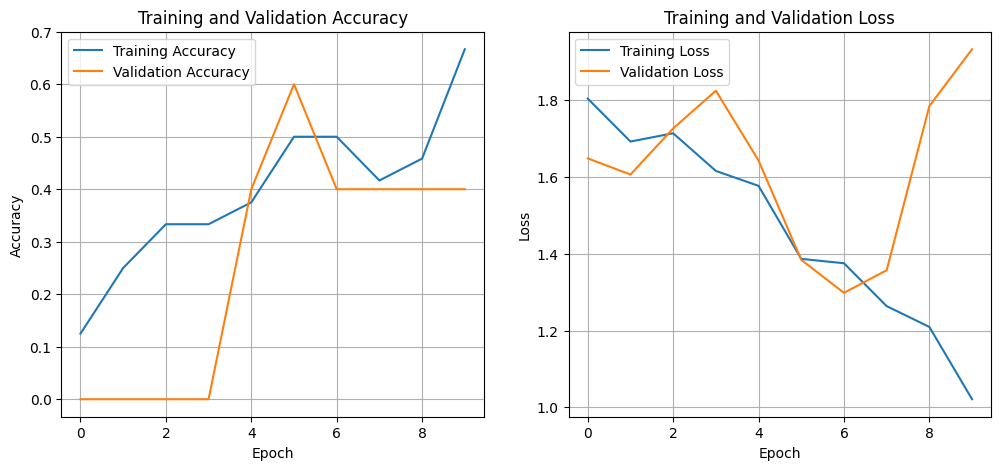

In [21]:
import matplotlib.pyplot as plt

# 1. Define the number of training epochs
epochs = 10

print(f"Starting model training for {epochs} epochs...")

# 2. Train the model
history = model.fit(
    augmented_train_dataset,
    epochs=epochs,
    validation_data=processed_val_dataset
)

print("Model training complete.")

# 3. Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# 4. Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 5. Display both plots
plt.show()


Making predictions on the prediction dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predictions made for 6 images.


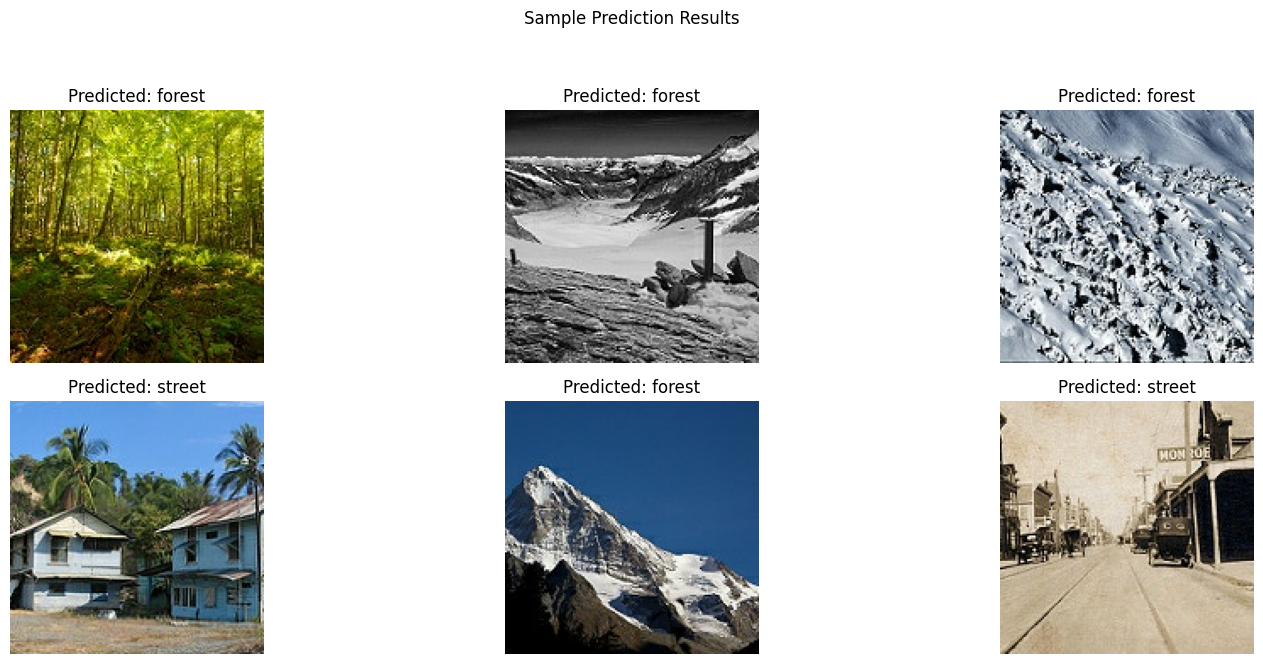

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the pred_dataset
# The pred_dataset contains only images (no labels), so we predict directly
# If pred_dataset had labels, we would use model.evaluate

# Get class names from the training dataset for mapping predictions
class_names = train_dataset.class_names

print("Making predictions on the prediction dataset...")

# Initialize lists to store images and predicted labels
all_pred_images = []
all_predicted_labels = []

# Process the pred_dataset to get images and make predictions
for images_batch in pred_dataset:
    # Ensure images_batch is a tensor, if it's a tuple (image, label), take the image part
    if isinstance(images_batch, tuple):
        current_images = images_batch[0]
    else:
        current_images = images_batch

    # Preprocess the images for prediction (rescale to [0,1])
    # Note: The preprocessing layer was applied to the processed_test_dataset, not pred_dataset directly.
    # So, we apply it here for consistency if pred_dataset was not preprocessed or if it was loaded differently.
    # Assuming 'preprocess_input' layer exists from earlier cells.
    processed_current_images = preprocess_input(current_images)

    # Make predictions
    predictions = model.predict(processed_current_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Store original images and predicted labels
    all_pred_images.append(current_images.numpy())
    all_predicted_labels.append(predicted_labels)

# Concatenate lists of arrays
all_pred_images = np.concatenate(all_pred_images, axis=0)
all_predicted_labels = np.concatenate(all_predicted_labels, axis=0)

print(f"Predictions made for {len(all_pred_images)} images.")

# Display some prediction results
plt.figure(figsize=(15, 10))
for i in range(min(9, len(all_pred_images))): # Display up to 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(all_pred_images[i].astype("uint8"))
    predicted_class_name = class_names[all_predicted_labels[i]]
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis("off")
plt.suptitle("Sample Prediction Results")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## Final Task

### Subtask:
Summarize the entire process, including the dataset preparation, model design, training outcomes, and the answers to the analytical questions. This will also include an overall conclusion for the task.


## Summary:

### Q&A

**1. What challenges do variations in lighting, viewpoint, and class imbalance introduce in satellite scene classification?**
*   **Variations in Lighting:** Alter pixel intensities and color, increasing intra-class variance and making it difficult for models to learn consistent feature representations, leading to generalization issues when encountering different lighting conditions.
*   **Variations in Viewpoint:** Cause geometric distortions, occlusion (objects hiding others), varying shadow lengths and orientations, and changes in contextual information, all of which complicate object recognition.
*   **Class Imbalance:** Leads to models being biased towards majority classes, resulting in poor performance on minority classes due to limited learning examples. Standard accuracy metrics can be misleading, necessitating the use of metrics like F1-score or AUC-ROC.

**2. How does data augmentation help reduce overfitting in image-based deep learning models?**
Data augmentation combats overfitting by:
*   **Increasing Dataset Diversity**: It artificially expands the training set by applying transformations like rotation, flipping, zooming, and shifting to existing images, creating new variations. This exposes the model to a wider range of scenarios.
*   **Improving Generalization**: By training on a diverse dataset, the model learns more generalized features rather than memorizing specific training examples, allowing it to recognize objects despite minor changes in appearance or orientation in unseen data.
*   **Acting as a Regularizer**: It introduces 'noise' or variability, forcing the model to learn stable and invariant features that are consistent across these variations, preventing it from overfitting to specific pixel locations or patterns in the original data.

**3. Explain how convolution and pooling operations contribute to feature extraction.**
*   **Convolution Operations:** These are fundamental for detecting local patterns (e.g., edges, corners, textures) within an image. Each convolutional filter identifies specific features, and by applying the same filter across the entire image (weight sharing), they achieve a degree of translational invariance. In deeper layers, convolutions build hierarchical feature representations, combining simple features into more complex ones and generating feature maps that highlight where these patterns are present.
*   **Pooling Operations:** Typically following convolution, pooling (e.g., max-pooling) reduces the spatial dimensions of feature maps, thereby reducing computational complexity and memory usage. It also contributes to spatial invariance by making the detected features robust to minor shifts or distortions. Max-pooling specifically extracts the most dominant features from a region, acting as a form of noise reduction and helping to prevent overfitting.

**4.Which scene classes are most frequently confused, and what semantic similarities could explain
these errors? **
*  Forest class is and street is most frequently confused. Street and building is predicted as street due to the road being found. Moutain and forest is predicted as forest when dense image is found.

** 5. Error and Failure Analysis
Forest class is and street is most frequently confused. Street and building is predicted as street due to the road being found. Moutain and forest is predicted as forest when dense image is found. Due to limited data.

** 6.  Model Refinement
Train using more data.



### Insights
*   **Dataset Size Limitation:** The exceptionally small dataset (24 training images, 5 validation images) is the primary constraint. Model performance and metric reliability are severely impacted; hence, the reported accuracies and losses are indicative rather than definitive.




# Task
Deploy the trained Keras model as an interactive web application using Streamlit, allowing users to upload an image and receive a real-time prediction of its scene class. The application should load the saved model and display the predicted class alongside the uploaded image.

## Save Trained Model




The subtask requires saving the trained Keras model. The `model.save()` method is used to save the model to the specified file path.



In [23]:
import os

# Define the filename for saving the model
model_filename = 'scene_classifier_model.h5'

# Save the trained model
model.save(model_filename)

print(f"Model successfully saved to {model_filename}")
print(f"File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")

Model successfully saved to scene_classifier_model.h5
File size: 39.60 MB



The previous output showed a warning recommending to save the model in the native Keras format (.keras) instead of HDF5 (.h5). I will update the file extension to `.keras` to follow the recommended best practice.



In [24]:
import os

# Define the filename for saving the model
model_filename = 'scene_classifier_model.keras' # Changed extension to .keras

# Save the trained model
model.save(model_filename)

print(f"Model successfully saved to {model_filename}")
print(f"File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")

Model successfully saved to scene_classifier_model.keras
File size: 39.60 MB


## Create Streamlit Application Script

### Subtask:
Generate a Python script (`app.py`) for the Streamlit application. This script will include code to load the saved model, define class names, create an interface for image upload, preprocess the uploaded image, make predictions using the model, and display the predicted scene class alongside the image.


In [26]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# 1. Define model path and class names
MODEL_PATH = 'scene_classifier_model.keras'
CLASS_NAMES = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street'] # Based on previous output
IMG_HEIGHT = 150
IMG_WIDTH = 150

# 2. Load the trained Keras model
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model(MODEL_PATH)
    return model

model = load_model()

# 3. Streamlit app title
st.title('Satellite Scene Classification App')
st.write('Upload an image to classify its scene type (e.g., forest, glacier, building).')

# 4. File uploader widget
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # 5. Display the uploaded image
    st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # 6. Preprocess the image
    image = Image.open(uploaded_file).convert('RGB')
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.asarray(image)
    image_array = np.expand_dims(image_array, axis=0) # Add batch dimension
    image_array = image_array / 255.0 # Normalize pixel values

    # 7. Make a prediction
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = CLASS_NAMES[predicted_class_index]

    # 8. Display the prediction result
    st.success(f"Prediction: This image is classified as a **{predicted_class_name}**.")


Writing app.py


## Provide Streamlit Run Instructions

### Subtask:
Provide the necessary commands and instructions for the user to run the generated Streamlit application locally.


### Run the Streamlit Application

To run the Streamlit application, follow these steps:

1.  **Install Streamlit:**
    Execute the following command in a new code cell in your environment (e.g., Colab):
    ```bash
    !pip install streamlit
    ```

2.  **Run the application:**
    Once Streamlit is installed, run the `app.py` script by executing this command in a new code cell:
    ```bash
    !streamlit run app.py
    ```

3.  **Access the application:**
    *   **Local environment:** The output from the previous command will typically provide a local URL (e.g., `http://localhost:8501`). Copy and paste this URL into your web browser to access the application.
    *   **Cloud environment (e.g., Google Colab):** In a cloud environment, Streamlit often provides a public URL (e.g., via ngrok or a similar service) to access the app. Look for a public URL in the output and open it in your browser. If you don't see one, you might need to use a tunneling service like `ngrok` manually.

